<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

Generating sample data...

Dataset shape: (10000, 9)
Target distribution:
y
0    0.7
1    0.3
Name: proportion, dtype: float64

Columns: ['month', 'age', 'income', 'credit_score', 'num_accounts', 'employment_years', 'debt_ratio', 'category', 'y']

Calculating WoE bins...
Creating bins...
Applying binning...
[INFO] converting into woe values ...
Analyzing 4 variables...


Variable 1/4: age

WoE Summary:
        Bin       WoE  Count %
[-inf,26.0)  0.073949    15.36
[26.0,30.0) -0.191676     7.27
[30.0,38.0)  0.088072    16.53
[38.0,46.0) -0.124500    15.70
 [46.0,inf)  0.013467    45.14


Generating Plot 1: WoE and Bin Distribution


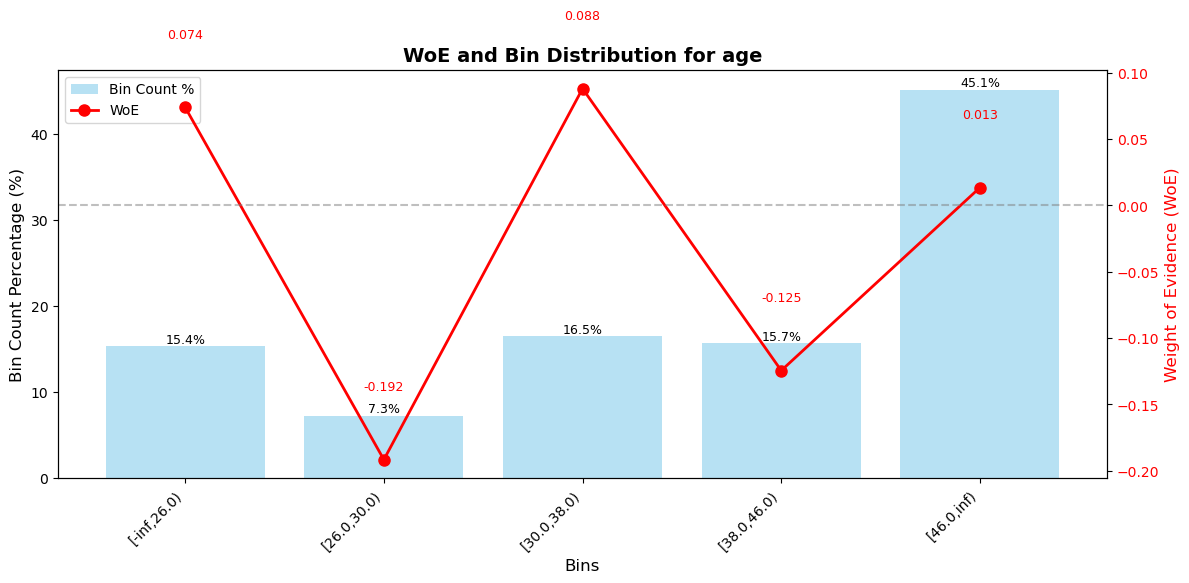


Generating Plot 2: Target Ratio Over Time


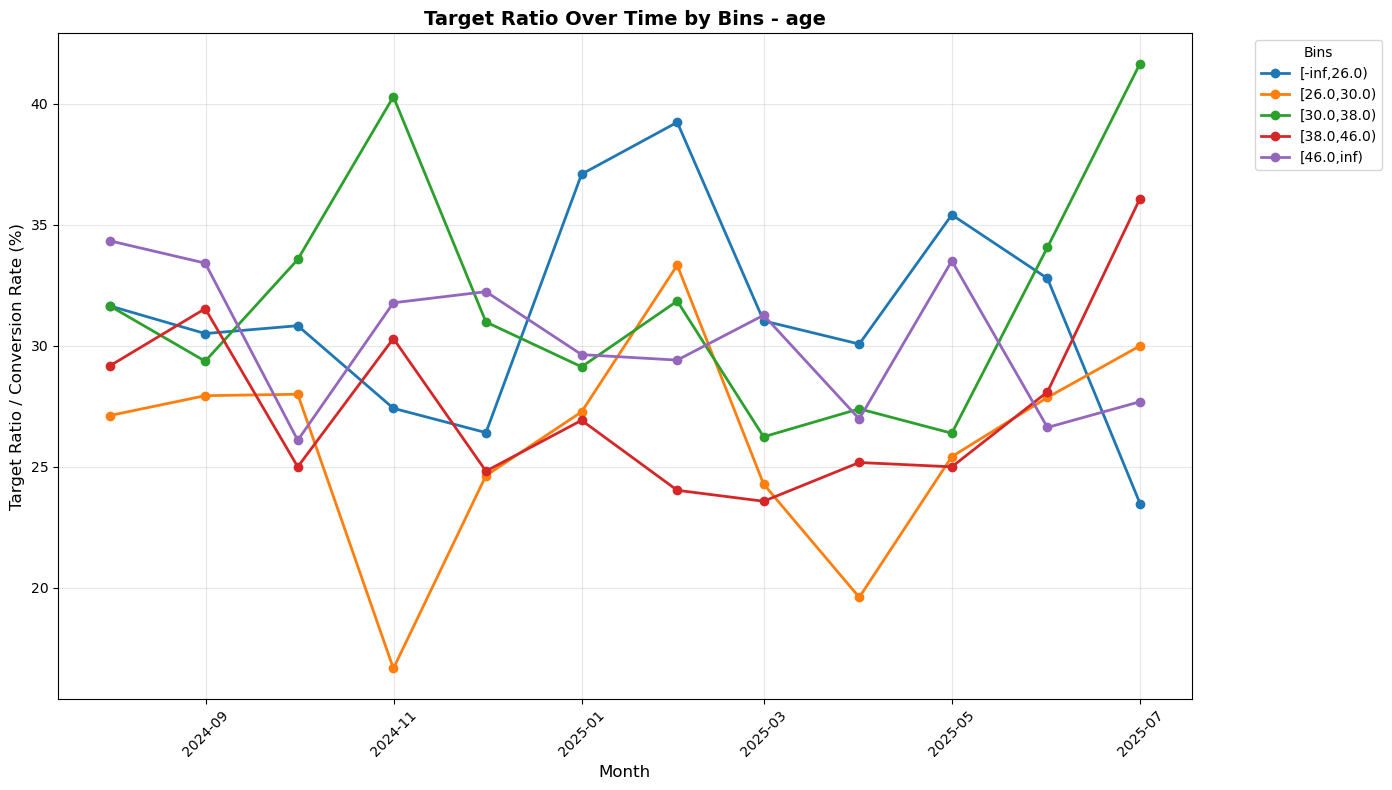


Generating Plot 3: Volume Distribution Over Time


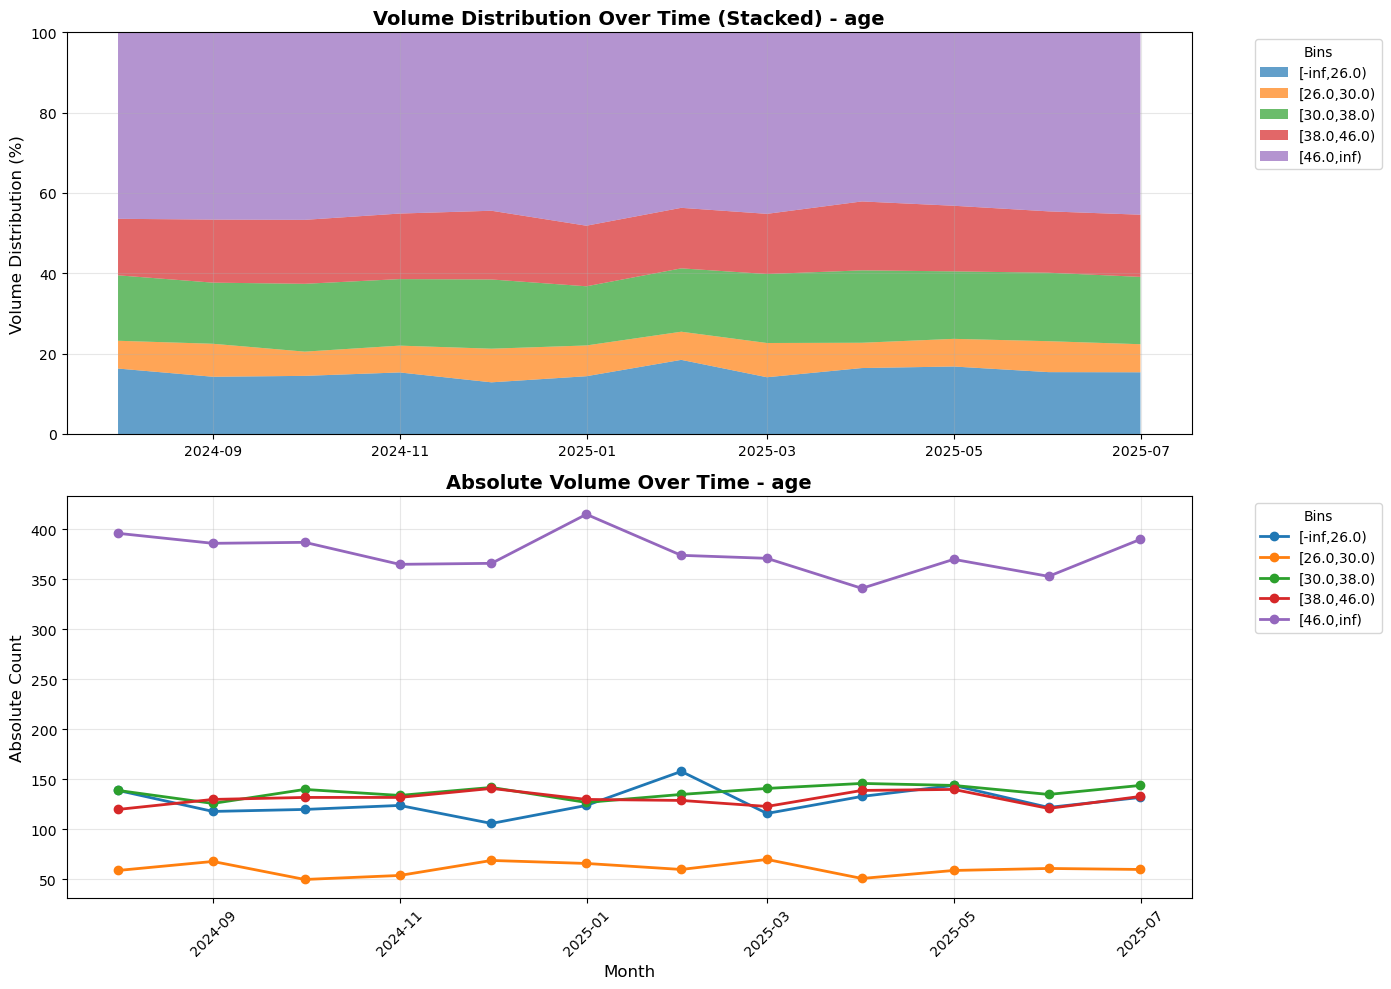


Variable 2/4: income

WoE Summary:
              Bin       WoE  Count %
   [-inf,30000.0) -0.210083    35.53
[30000.0,40000.0) -0.116035    22.70
[40000.0,80000.0)  0.151250    36.22
    [80000.0,inf)  0.662994     5.55


Generating Plot 1: WoE and Bin Distribution


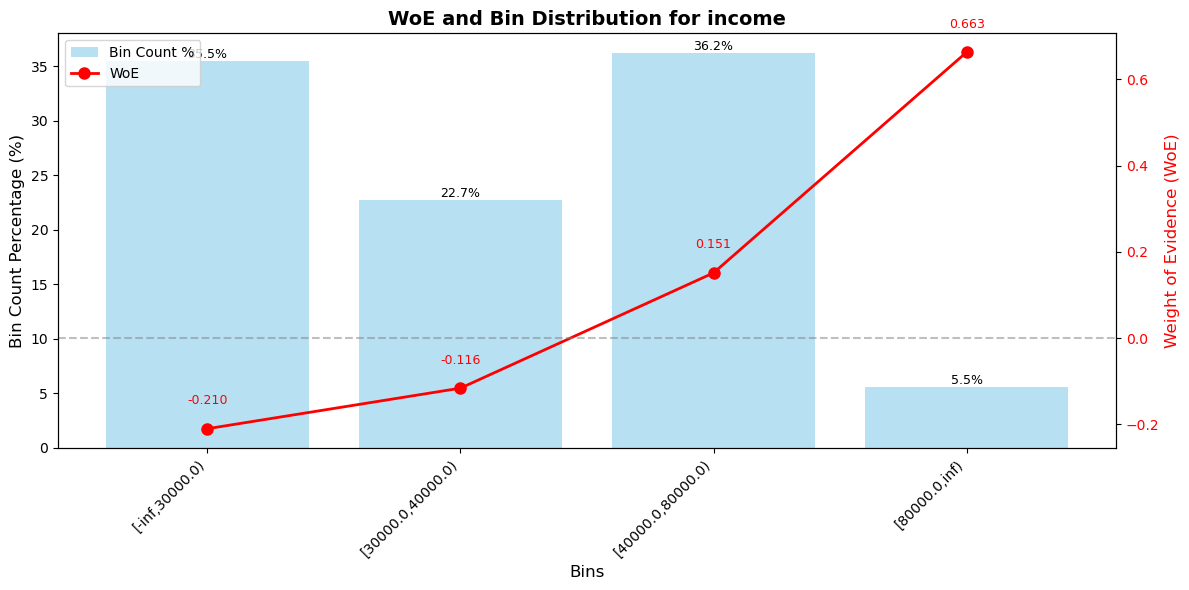


Generating Plot 2: Target Ratio Over Time


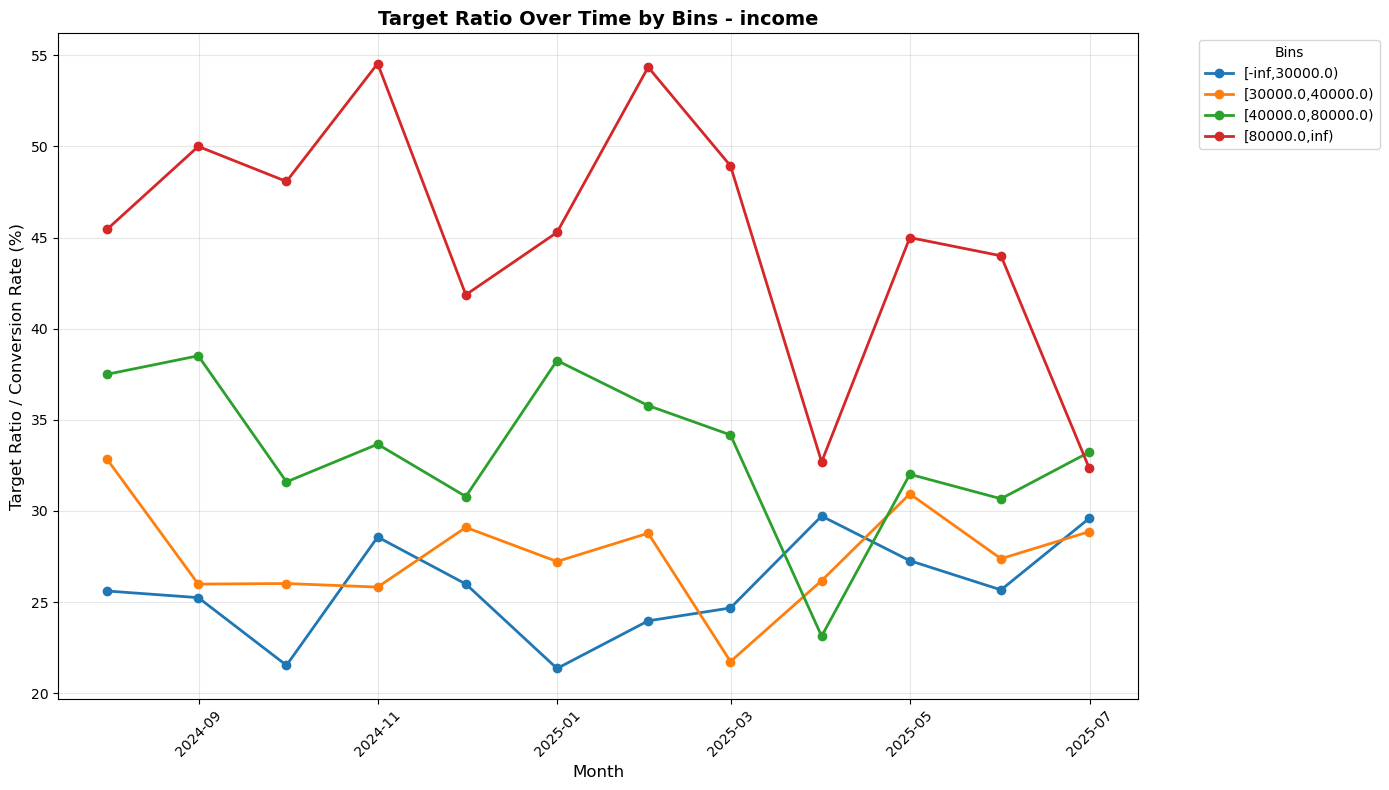


Generating Plot 3: Volume Distribution Over Time


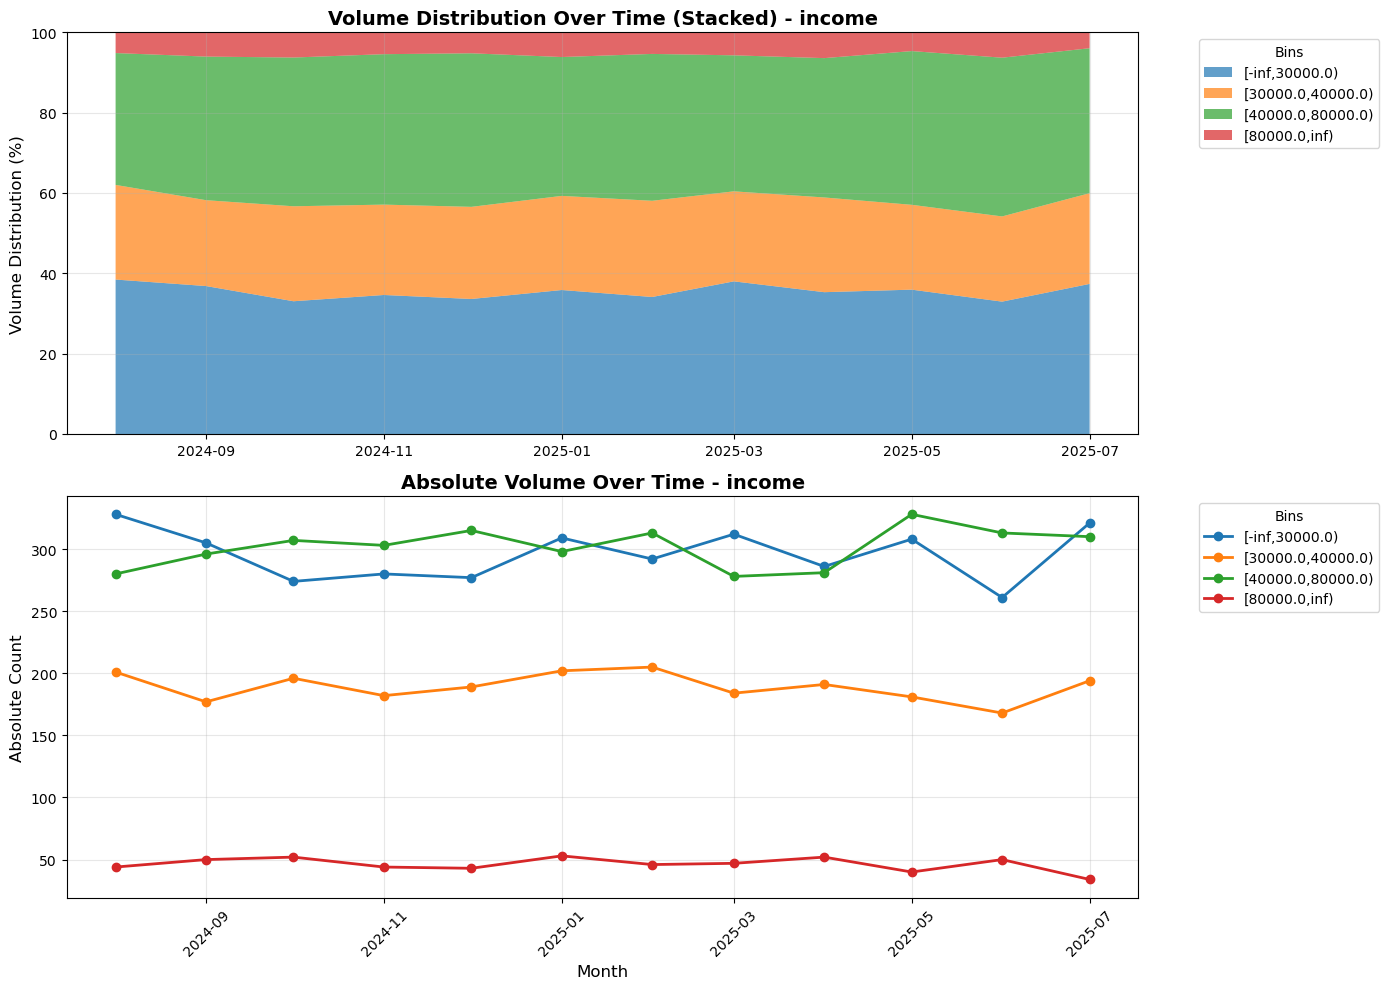


Variable 3/4: credit_score

WoE Summary:
          Bin       WoE  Count %
 [-inf,420.0) -1.759064    21.97
[420.0,560.0) -0.894894    25.90
[560.0,700.0)  0.191348    24.85
  [700.0,inf)  1.218056    27.28


Generating Plot 1: WoE and Bin Distribution


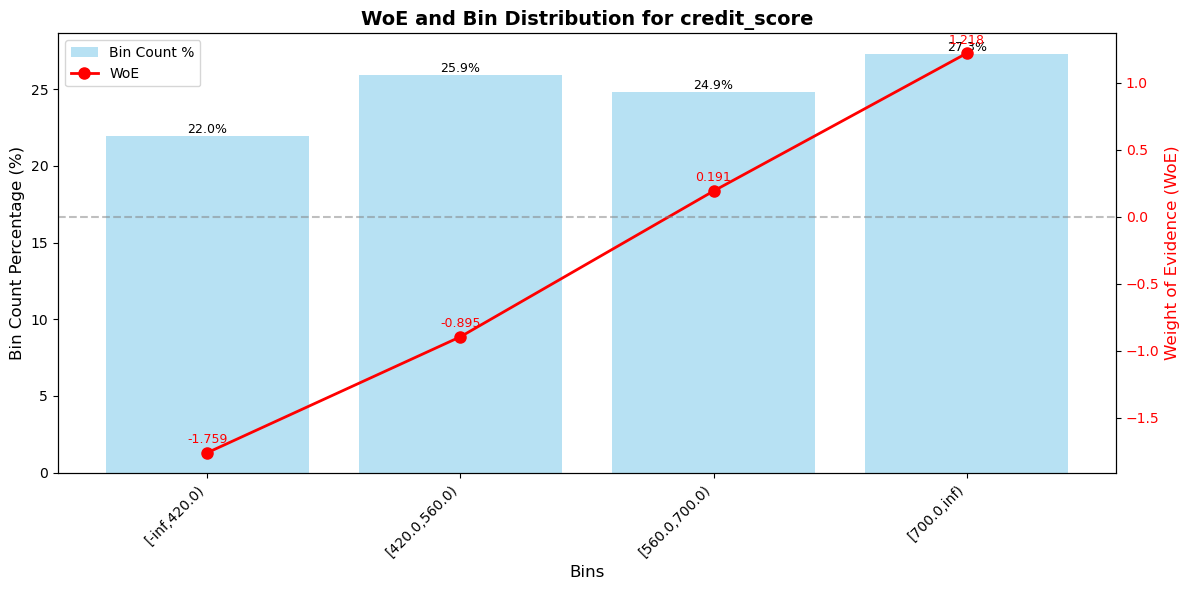


Generating Plot 2: Target Ratio Over Time


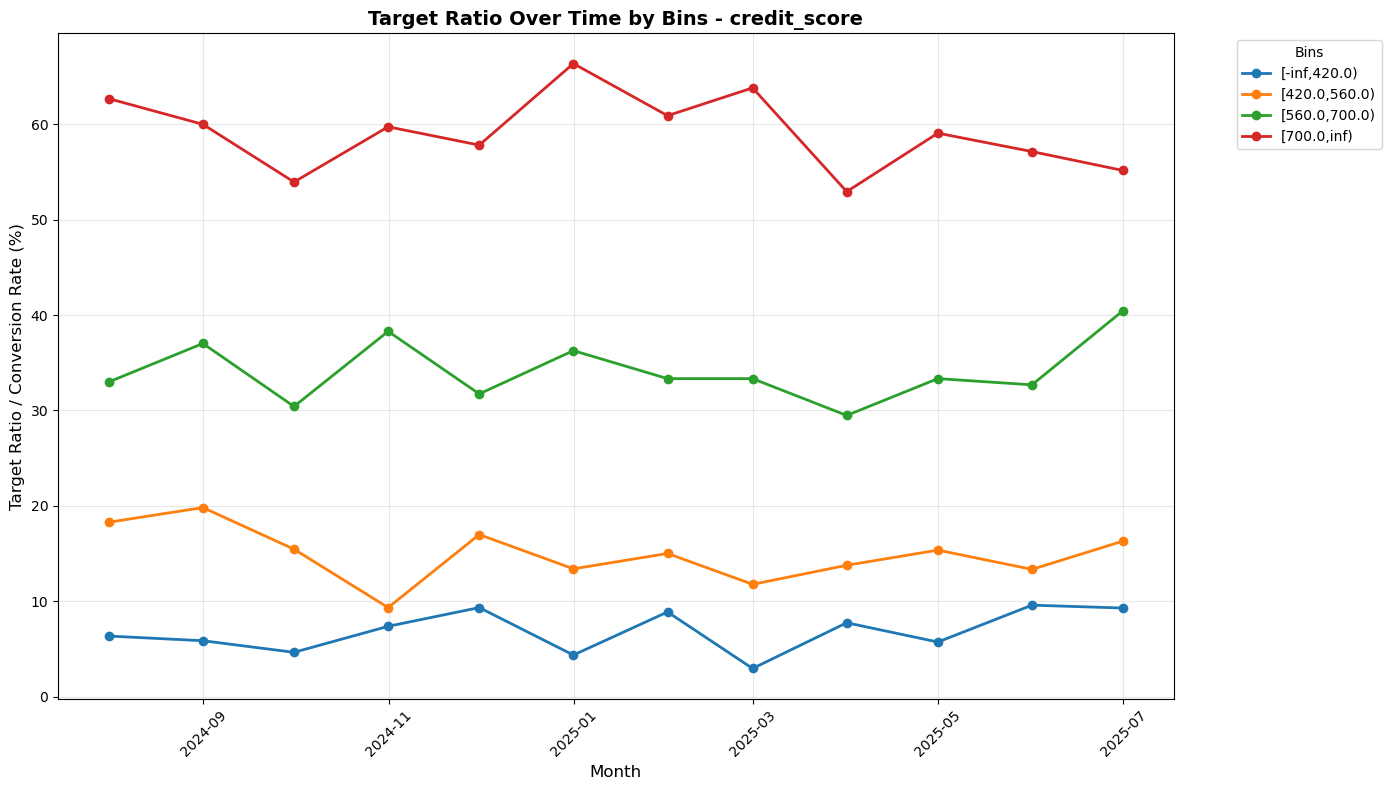


Generating Plot 3: Volume Distribution Over Time


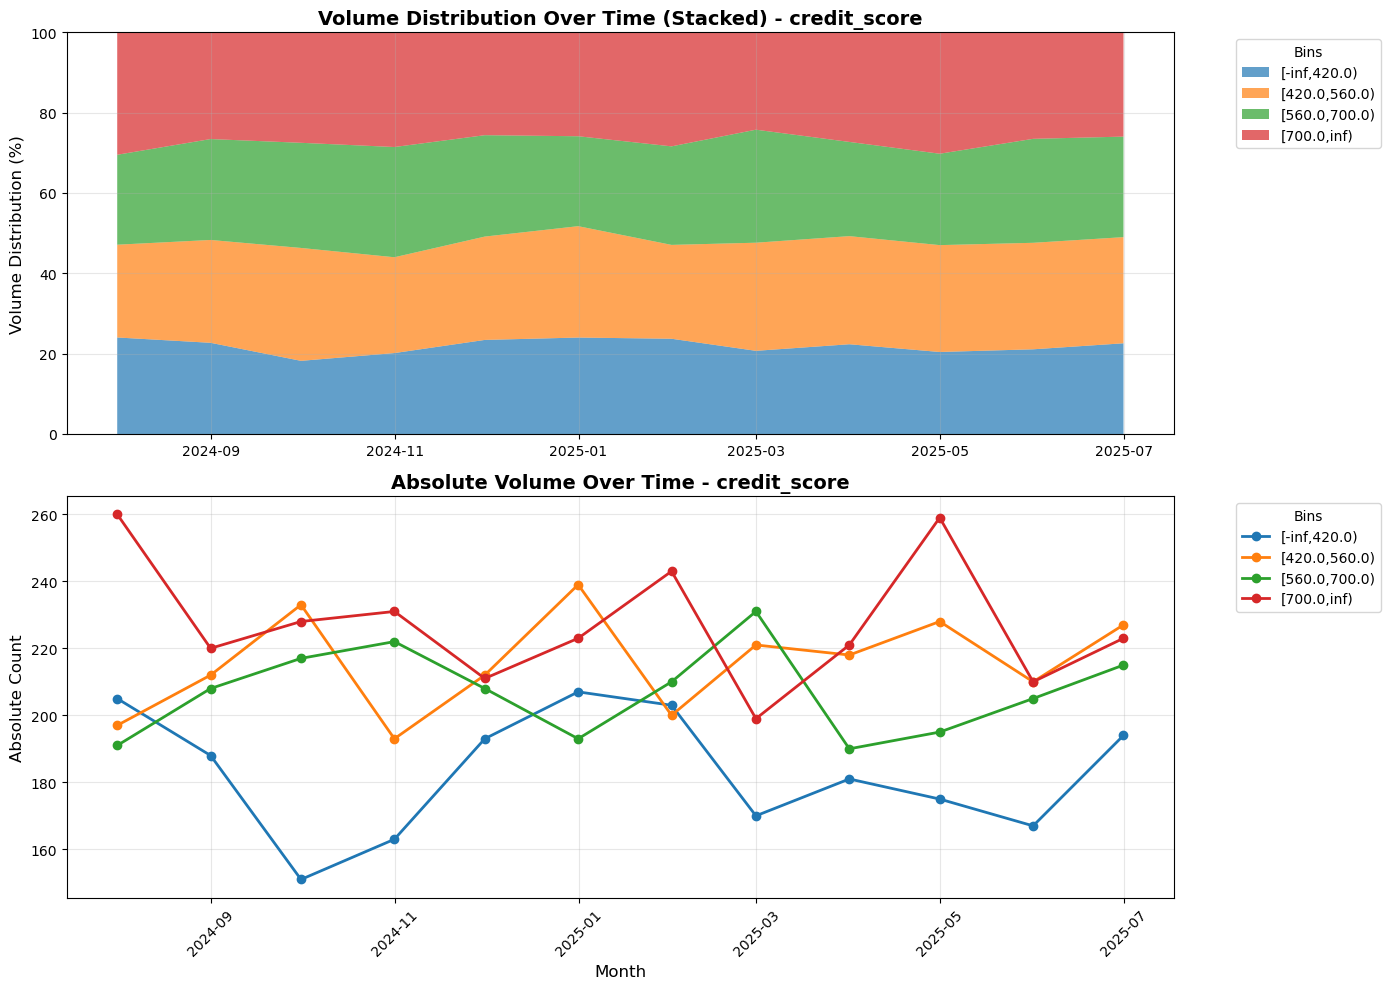


Variable 4/4: debt_ratio

WoE Summary:
                      Bin       WoE  Count %
               [-inf,0.1)  0.784450    11.46
                [0.1,0.2)  0.369262    22.68
[0.2,0.30000000000000004)  0.098860    24.10
[0.30000000000000004,0.5) -0.440087    30.56
                [0.5,inf) -1.082385    11.20


Generating Plot 1: WoE and Bin Distribution


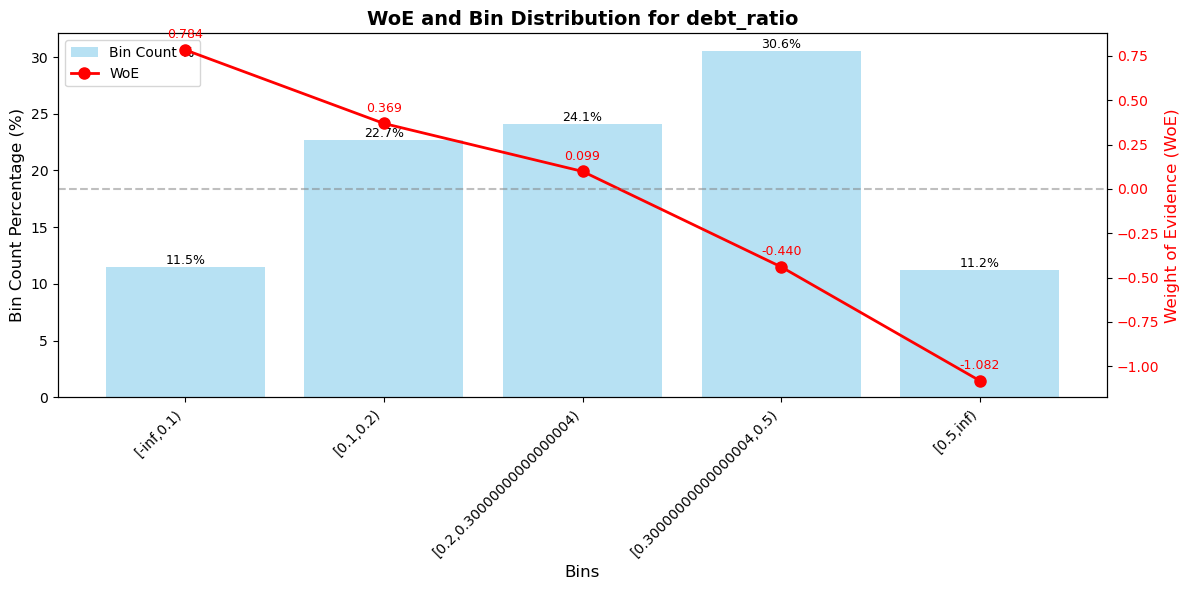


Generating Plot 2: Target Ratio Over Time


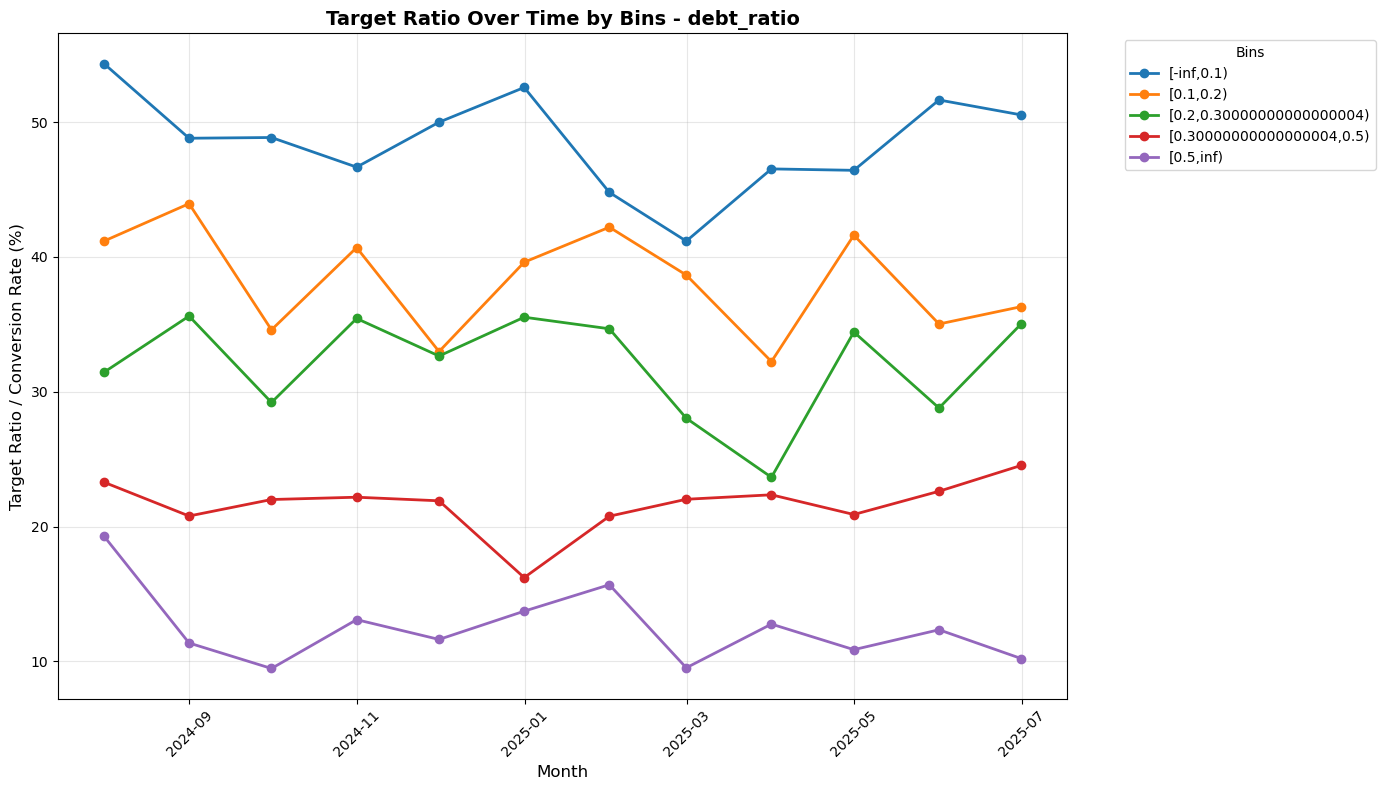


Generating Plot 3: Volume Distribution Over Time


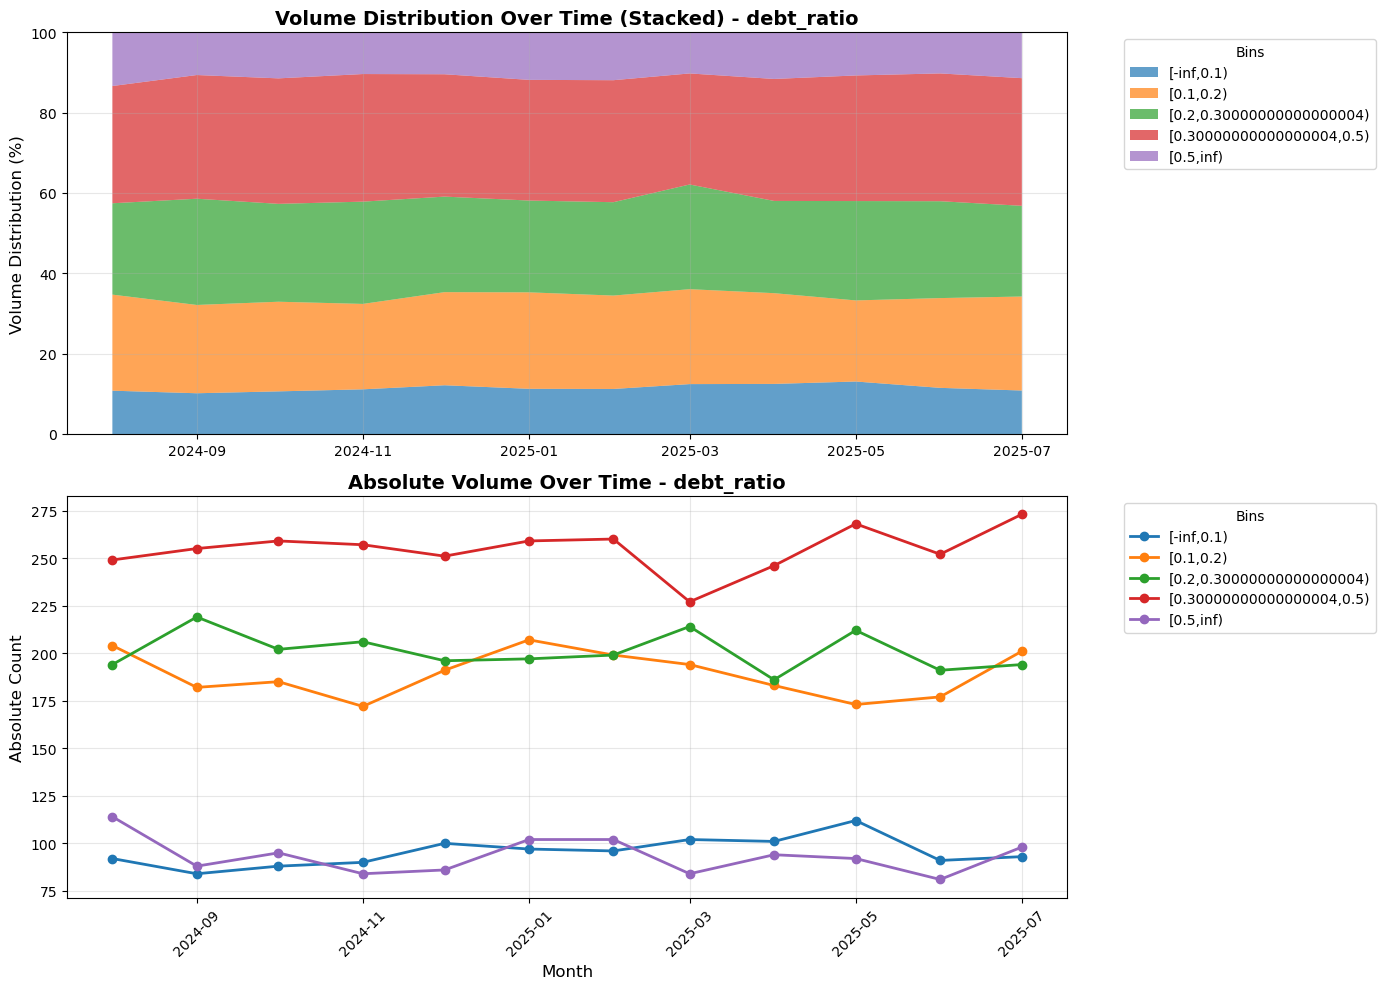

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scorecardpy as sc
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots


class WoETimeAnalysisRobust:
    """
    A robust class to perform Weight of Evidence analysis with temporal visualization
    """
    
    def __init__(self, df, target_col='y', date_col='month'):
        """
        Initialize the WoE analysis
        
        Parameters:
        -----------
        df : pandas.DataFrame
            Input dataframe
        target_col : str
            Name of the target column (binary: 0 or 1)
        date_col : str
            Name of the date column
        """
        self.df = df.copy()
        self.target_col = target_col
        self.date_col = date_col
        self.bins_dict = {}
        self.woe_dict = {}
        self.df_binned = None
        
    def calculate_woe_bins(self, max_num_bin=5, min_perc_fine_bin=0.05):
        """
        Calculate WoE and create bins for all numeric and categorical variables
        """
        # Exclude target and date columns
        feature_cols = [col for col in self.df.columns 
                       if col not in [self.target_col, self.date_col]]
        
        # Create bins using scorecardpy
        print("Creating bins...")
        self.bins_dict = sc.woebin(
            self.df[feature_cols + [self.target_col]], 
            y=self.target_col,
            max_num_bin=max_num_bin,
            min_perc_fine_bin=min_perc_fine_bin,
            print_info=False
        )
        
        # Apply binning to get WoE values
        print("Applying binning...")
        self.df_binned = sc.woebin_ply(self.df, self.bins_dict)
        
        # Store WoE information
        for var in feature_cols:
            if var in self.bins_dict:
                self.woe_dict[var] = self.bins_dict[var][['bin', 'woe', 'count_distr', 
                                                          'good', 'bad', 'count']].copy()
    
    def get_binned_column_name(self, variable):
        """
        Get the actual column name after binning (handles _woe suffix)
        """
        possible_names = [f"{variable}_woe", f"{variable}_bin", variable]
        for name in possible_names:
            if name in self.df_binned.columns:
                return name
        return None
    
    def plot_woe_and_bin_distribution(self, variable):
        """
        Plot 1: WoE values and bin count percentage
        """
        if variable not in self.woe_dict:
            print(f"Variable {variable} not found in WoE dictionary")
            return
        
        woe_data = self.woe_dict[variable]
        
        fig, ax1 = plt.subplots(figsize=(12, 6))
        
        # Bar plot for bin count percentage
        bars = ax1.bar(range(len(woe_data)), woe_data['count_distr'] * 100, 
                       alpha=0.6, color='skyblue', label='Bin Count %')
        
        # Add percentage labels on bars
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
        
        ax1.set_xlabel('Bins', fontsize=12)
        ax1.set_ylabel('Bin Count Percentage (%)', fontsize=12)
        ax1.set_xticks(range(len(woe_data)))
        ax1.set_xticklabels(woe_data['bin'], rotation=45, ha='right')
        
        # Create second y-axis for WoE
        ax2 = ax1.twinx()
        line = ax2.plot(range(len(woe_data)), woe_data['woe'], 
                       'ro-', linewidth=2, markersize=8, label='WoE')
        
        # Add WoE value labels
        for i, woe_val in enumerate(woe_data['woe']):
            ax2.text(i, woe_val + 0.05, f'{woe_val:.3f}', 
                    ha='center', va='bottom', fontsize=9, color='red')
        
        ax2.set_ylabel('Weight of Evidence (WoE)', fontsize=12, color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        
        # Add horizontal line at WoE = 0
        ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        
        # Combine legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        
        plt.title(f'WoE and Bin Distribution for {variable}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    def create_bin_mapping(self, variable):
        """
        Create a mapping from original values to bins
        """
        bins_info = self.bins_dict[variable]
        bin_mapping = {}
        
        for _, row in bins_info.iterrows():
            bin_label = row['bin']
            
            # Get the values that belong to this bin
            if variable in self.df.select_dtypes(include=[np.number]).columns:
                # Numeric variable - use the binned column
                binned_col = self.get_binned_column_name(variable)
                if binned_col:
                    # Find which values map to this bin
                    mask = self.df_binned[binned_col] == row['woe']
                    original_values = self.df.loc[mask, variable].unique()
                    for val in original_values:
                        bin_mapping[val] = bin_label
            else:
                # Categorical variable
                if '%,%' in str(bin_label):
                    # Multiple categories in one bin
                    categories = bin_label.replace('%,%', ',').replace('%', '').split(',')
                    for cat in categories:
                        bin_mapping[cat.strip()] = bin_label
                else:
                    # Single category
                    cat_value = bin_label.replace('%', '') if '%' in str(bin_label) else bin_label
                    bin_mapping[cat_value] = bin_label
        
        return bin_mapping
    
    def prepare_temporal_data_simple(self, variable):
        """
        Simpler approach to prepare temporal data
        """
        # Create a dataframe with date, target, and the binned variable
        binned_col = self.get_binned_column_name(variable)
        
        if binned_col is None:
            raise ValueError(f"Could not find binned column for {variable}")
        
        # Create mapping from WoE values to bin labels
        woe_to_bin = dict(zip(self.bins_dict[variable]['woe'], 
                             self.bins_dict[variable]['bin']))
        
        # Create temporal dataframe
        df_temp = pd.DataFrame({
            self.date_col: self.df[self.date_col],
            self.target_col: self.df[self.target_col],
            'woe_value': self.df_binned[binned_col],
            variable: self.df[variable]
        })
        
        # Map WoE values to bin labels
        df_temp['bin'] = df_temp['woe_value'].map(woe_to_bin)
        
        # Ensure month is datetime
        df_temp[self.date_col] = pd.to_datetime(df_temp[self.date_col])
        
        # Remove any unmapped values
        df_temp = df_temp[df_temp['bin'].notna()].copy()
        
        return df_temp
    
    def plot_target_ratio_over_time(self, variable):
        """
        Plot 2: Target ratio (conversion rate) of bins over time
        """
        if variable not in self.bins_dict:
            print(f"Variable {variable} not found in bins dictionary")
            return
        
        try:
            df_temp = self.prepare_temporal_data_simple(variable)
        except Exception as e:
            print(f"Error preparing temporal data: {e}")
            return
        
        # Calculate conversion rate by bin and month
        conversion_by_time = df_temp.groupby([self.date_col, 'bin'])[self.target_col].agg([
            'mean',  # Conversion rate
            'count'  # Volume for reliability
        ]).reset_index()
        
        # Plot
        plt.figure(figsize=(14, 8))
        
        # Get unique bins ordered by their appearance in the original bins_dict
        bin_order = self.bins_dict[variable]['bin'].tolist()
        unique_bins = [b for b in bin_order if b in conversion_by_time['bin'].unique()]
        
        # Plot each bin's conversion rate over time
        for bin_val in unique_bins:
            bin_data = conversion_by_time[conversion_by_time['bin'] == bin_val]
            plt.plot(bin_data[self.date_col], bin_data['mean'] * 100, 
                    marker='o', linewidth=2, markersize=6, label=f'{bin_val}')
        
        plt.xlabel('Month', fontsize=12)
        plt.ylabel('Target Ratio / Conversion Rate (%)', fontsize=12)
        plt.title(f'Target Ratio Over Time by Bins - {variable}', fontsize=14, fontweight='bold')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Bins')
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def plot_volume_distribution_over_time(self, variable):
        """
        Plot 3: Volume distribution of bins over time
        """
        if variable not in self.bins_dict:
            print(f"Variable {variable} not found in bins dictionary")
            return
        
        try:
            df_temp = self.prepare_temporal_data_simple(variable)
        except Exception as e:
            print(f"Error preparing temporal data: {e}")
            return
        
        # Calculate volume distribution by month
        volume_by_time = df_temp.groupby([self.date_col, 'bin']).size().reset_index(name='count')
        
        # Calculate percentage within each month
        volume_by_time['total_monthly'] = volume_by_time.groupby(self.date_col)['count'].transform('sum')
        volume_by_time['percentage'] = (volume_by_time['count'] / volume_by_time['total_monthly']) * 100
        
        # Get bin order
        bin_order = self.bins_dict[variable]['bin'].tolist()
        available_bins = [b for b in bin_order if b in volume_by_time['bin'].unique()]
        
        # Pivot for stacked area chart
        volume_pivot = volume_by_time.pivot(index=self.date_col, 
                                          columns='bin', 
                                          values='percentage').fillna(0)
        
        # Reorder columns based on bin_order
        volume_pivot = volume_pivot[[col for col in available_bins if col in volume_pivot.columns]]
        
        # Create plots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
        
        # Stacked area chart
        ax1.stackplot(volume_pivot.index, 
                     [volume_pivot[col] for col in volume_pivot.columns],
                     labels=volume_pivot.columns,
                     alpha=0.7)
        
        ax1.set_ylabel('Volume Distribution (%)', fontsize=12)
        ax1.set_title(f'Volume Distribution Over Time (Stacked) - {variable}', 
                     fontsize=14, fontweight='bold')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Bins')
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(0, 100)
        
        # Line chart for absolute volumes
        for bin_val in available_bins:
            bin_data = volume_by_time[volume_by_time['bin'] == bin_val]
            ax2.plot(bin_data[self.date_col], bin_data['count'], 
                    marker='o', linewidth=2, markersize=6, label=f'{bin_val}')
        
        ax2.set_xlabel('Month', fontsize=12)
        ax2.set_ylabel('Absolute Count', fontsize=12)
        ax2.set_title(f'Absolute Volume Over Time - {variable}', 
                     fontsize=14, fontweight='bold')
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Bins')
        ax2.grid(True, alpha=0.3)
        
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def analyze_all_variables(self, variables=None):
        """
        Perform complete analysis for all or specified variables
        """
        if variables is None:
            variables = [col for col in self.df.columns 
                        if col not in [self.target_col, self.date_col]]
        
        print(f"Analyzing {len(variables)} variables...\n")
        
        for i, var in enumerate(variables, 1):
            print(f"\n{'='*60}")
            print(f"Variable {i}/{len(variables)}: {var}")
            print(f"{'='*60}\n")
            
            # Check if variable exists in bins
            if var not in self.bins_dict:
                print(f"Skipping {var} - not suitable for binning")
                continue
            
            # Display WoE summary
            print("WoE Summary:")
            woe_summary = self.woe_dict[var][['bin', 'woe', 'count_distr']].copy()
            woe_summary['count_distr'] = (woe_summary['count_distr'] * 100).round(2)
            woe_summary.columns = ['Bin', 'WoE', 'Count %']
            print(woe_summary.to_string(index=False))
            print("\n")
            
            # Generate all three plots
            print("Generating Plot 1: WoE and Bin Distribution")
            self.plot_woe_and_bin_distribution(var)
            
            print("\nGenerating Plot 2: Target Ratio Over Time")
            self.plot_target_ratio_over_time(var)
            
            print("\nGenerating Plot 3: Volume Distribution Over Time")
            self.plot_volume_distribution_over_time(var)


# Example usage with synthetic data
def generate_sample_data(n_samples=10000, n_months=12):
    """
    Generate synthetic data for demonstration
    """
    np.random.seed(42)
    
    # Generate date range
    start_date = datetime.now() - timedelta(days=365)
    dates = pd.date_range(start=start_date, periods=n_months, freq='M')
    
    # Create sample data
    data = {
        'month': np.random.choice(dates, n_samples),
        'age': np.random.randint(18, 70, n_samples),
        'income': np.random.lognormal(10.5, 0.5, n_samples),
        'credit_score': np.random.randint(300, 850, n_samples),
        'num_accounts': np.random.poisson(3, n_samples),
        'employment_years': np.random.exponential(5, n_samples),
        'debt_ratio': np.random.beta(2, 5, n_samples),
        'category': np.random.choice(['A', 'B', 'C', 'D'], n_samples, p=[0.3, 0.3, 0.25, 0.15])
    }
    
    df = pd.DataFrame(data)
    
    # Create target variable with some logic
    score = (
        (df['credit_score'] - 300) / 550 * 0.3 +
        (df['income'] / df['income'].max()) * 0.2 +
        (1 - df['debt_ratio']) * 0.3 +
        (df['employment_years'] / 20) * 0.2
    )
    
    # Add some randomness and create binary target
    score += np.random.normal(0, 0.1, n_samples)
    df['y'] = (score > np.percentile(score, 70)).astype(int)
    
    return df


# Main execution
if __name__ == "__main__":
    # Generate or load your data
    print("Generating sample data...")
    df = generate_sample_data(n_samples=10000, n_months=12)
    
    print(f"\nDataset shape: {df.shape}")
    print(f"Target distribution:\n{df['y'].value_counts(normalize=True)}")
    print(f"\nColumns: {list(df.columns)}")
    
    # Initialize WoE analysis
    woe_analyzer = WoETimeAnalysisRobust(df, target_col='y', date_col='month')
    
    # Calculate WoE bins
    print("\nCalculating WoE bins...")
    woe_analyzer.calculate_woe_bins(max_num_bin=5, min_perc_fine_bin=0.05)
    
    # Analyze specific variables
    variables_to_analyze = ['age', 'income', 'credit_score', 'debt_ratio']
    woe_analyzer.analyze_all_variables(variables=variables_to_analyze)
    
    # For production use with your own data:
    # 1. Load your data
    # df = pd.read_csv('your_data.csv')
    # 
    # 2. Ensure your date column is in datetime format
    # df['month'] = pd.to_datetime(df['month'])
    # 
    # 3. Initialize and run analysis
    # woe_analyzer = WoETimeAnalysisRobust(df, target_col='y', date_col='month')
    # woe_analyzer.calculate_woe_bins()
    # woe_analyzer.analyze_all_variables()

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   month             10000 non-null  datetime64[ns]
 1   age               10000 non-null  int32         
 2   income            10000 non-null  float64       
 3   credit_score      10000 non-null  int32         
 4   num_accounts      10000 non-null  int32         
 5   employment_years  10000 non-null  float64       
 6   debt_ratio        10000 non-null  float64       
 7   category          10000 non-null  object        
 8   y                 10000 non-null  int32         
dtypes: datetime64[ns](1), float64(3), int32(4), object(1)
memory usage: 547.0+ KB


In [5]:
df

,month,age,income,credit_score,num_accounts,employment_years,debt_ratio,category,y
0,2025-01-31 20:30:03.589735,48,35447.878372,590,2,2.235477,0.223251,B,0
1,2024-10-31 20:30:03.589735,58,32680.716717,659,5,8.440637,0.171497,D,0
2,2025-05-31 20:30:03.589735,27,63253.198079,578,4,1.183139,0.253336,C,0
3,2025-02-28 20:30:03.589735,19,62592.706569,696,5,8.804833,0.119793,D,1
4,2024-11-30 20:30:03.589735,55,88482.404796,441,2,4.014939,0.239736,B,1
...,...,...,...,...,...,...,...,...,...
9995,2025-03-31 20:30:03.589735,64,30959.455446,648,3,5.048553,0.276007,D,0
9996,2025-04-30 20:30:03.589735,38,65287.164066,618,4,6.826866,0.173455,A,0
9997,2025-02-28 20:30:03.589735,37,24253.025628,719,2,1.068564,0.096098,A,1
9998,2025-02-28 20:30:03.589735,40,47932.997215,356,6,7.038024,0.304462,C,0
